# Neural Machine Translation

Welcome to your first programming assignment for this week! 

* You will build a Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25"). 
* You will do this using an attention model, one of the most sophisticated sequence-to-sequence models. 

In [1]:
from nmt_utils import *
import torch
import torch.nn as nn
import torch.nn.functional as F

<a name='1'></a>
## 1 - Translating Human Readable Dates Into Machine Readable Dates

* The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. 
* However, language translation requires massive datasets and usually takes days of training on GPUs. 
* To give you a place to experiment with these models without using massive datasets, we will perform a simpler "date translation" task. 
* The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) 
* The network will translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). 
* We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 

<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

<a name='1-1'></a>
### 1.1 - Dataset

We will train the model on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [109]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 16247.86it/s]


In [4]:
dataset[:10]

[('8 jul 1992', '1992-07-08'),
 ('20.07.70', '1970-07-20'),
 ('8/7/14', '2014-08-07'),
 ('friday february 21 1986', '1986-02-21'),
 ('wednesday november 29 1989', '1989-11-29'),
 ('thursday june 19 1980', '1980-06-19'),
 ('friday august 4 2000', '2000-08-04'),
 ('27 sep 1978', '1978-09-27'),
 ('19 sep 1976', '1976-09-19'),
 ('wednesday may 26 1993', '1993-05-26')]

You've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
    - **Note**: These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. 
- We will set Tx=30 
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set Ty=10
    - "YYYY-MM-DD" is 10 characters long.

In [5]:
human_vocab

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34,
 '<unk>': 35,
 '<pad>': 36}

In [6]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xoh = Xoh.to(device)
Yoh = Yoh.to(device)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: torch.Size([10000, 30, 37])
Yoh.shape: torch.Size([10000, 10, 11])


You now have:
- `X`: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`. 
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >). 
    - `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`. 
    - `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0.
    - `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`
    - Each index in `Y` is converted to the one-hot representation. 
    - `Yoh.shape = (m, Ty, len(machine_vocab))`. 
    - `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

* Let's also look at some examples of preprocessed training examples. 
* Feel free to play with `index` in the cell below to navigate the dataset and see how source/target dates are preprocessed. 

In [7]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 8 jul 1992
Target date: 1992-07-08

Source after preprocessing (indices): [11  0 22 31 23  0  4 12 12  5 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  3  0  1  8  0  1  9]

Source after preprocessing (one-hot): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')
Target after preprocessing (one-hot): tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0.,

<a name='2'></a>
## 2 - Neural Machine Translation with Attention

* If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. 
* Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 
* The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

<a name='2-1'></a>
### 2.1 - Attention Mechanism

In this part, you will implement the attention mechanism presented in the lecture videos. 
* Here is a figure to remind you how the model works. 
    * The diagram on the left shows the attention model. 
    * The diagram on the right shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$.
    * The attention variables $\alpha^{\langle t, t' \rangle}$ are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>


Here are some properties of the model that you may notice: 

#### Pre-attention and Post-attention LSTMs on both sides of the attention mechanism
- There are two separate LSTMs in this model (see diagram on the left): pre-attention and post-attention LSTMs.
- *Pre-attention* Bi-LSTM is the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism.
    - The attention mechanism is shown in the middle of the left-hand diagram.
    - The pre-attention Bi-LSTM goes through $T_x$ time steps
- *Post-attention* LSTM: at the top of the diagram comes *after* the attention mechanism. 
    - The post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$ from one time step to the next. 

#### An LSTM has both a hidden state and cell state
* In the lecture videos, we were using only a basic RNN for the post-attention sequence model
    * This means that the state captured by the RNN was outputting only the hidden state $s^{\langle t\rangle}$. 
* In this assignment, we are using an LSTM instead of a basic RNN.
    * So the LSTM has both the hidden state $s^{\langle t\rangle}$ and the cell state $c^{\langle t\rangle}$. 

#### Each time step does not use predictions from the previous time step
* Unlike previous text generation examples earlier in the course, in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input.
* The post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
* We have designed the model this way because **unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date**.

#### Concatenation of hidden states from the forward and backward pre-attention LSTMs
- $\overrightarrow{a}^{\langle t \rangle}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow{a}^{\langle t \rangle}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: the concatenation of the activations of both the forward-direction $\overrightarrow{a}^{\langle t \rangle}$ and backward-directions $\overleftarrow{a}^{\langle t \rangle}$ of the pre-attention Bi-LSTM. 

#### Computing "energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
- Recall in the lesson videos "Attention Model", at time 6:45 to 8:16, the definition of "e" as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
    - "e" is called the "energies" variable.
    - $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
    - $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
    - $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
    - $e^{\langle t, t' \rangle}$ is then used when computing the attention $a^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.

- The diagram on the right of figure 1 uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times.
- Then it uses `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
- The concatenation of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ is fed into a "Dense" layer, which computes $e^{\langle t, t' \rangle}$. 
- $e^{\langle t, t' \rangle}$ is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$.
- Note that the diagram doesn't explicitly show variable $e^{\langle t, t' \rangle}$, but $e^{\langle t, t' \rangle}$ is above the Dense layer and below the Softmax layer in the diagram in the right half of figure 1.
- We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

#### Implementation Details
   
Let's implement this neural translator. You will start by implementing two functions: `one_step_attention()` and `model()`.

#### one_step_attention
* The inputs to the one_step_attention at time step $t$ are:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM 
* one_step_attention computes:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights
    - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

##### Clarifying 'context' and 'c'
- In the lecture videos, the context was denoted $c^{\langle t \rangle}$
- In the assignment, we are calling the context $context^{\langle t \rangle}$.
    - This is to avoid confusion with the post-attention LSTM's internal memory cell variable, which is also denoted $c^{\langle t \rangle}$.

### Attention

In [45]:
class AttentionMechanism(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size):
        super(AttentionMechanism, self).__init__()

        # Linear layers
        self.attn_layer1 = nn.Linear(encoder_hidden_size * 2 + decoder_hidden_size, 10)
        self.attn_layer2 = nn.Linear(10, 1)

    def forward(self, encoder_outputs, decoder_hidden):
        """
        encoder_outputs -- output from the encoder Bi-LSTM, shape: (batch_size, sequence_length, 2 * encoder_hidden_size)
        decoder_hidden -- last hidden state of the decoder LSTM, shape: (batch_size, decoder_hidden_size)
        """
        # Get the sequence length and batch size from encoder outputs
        seq_len = encoder_outputs.size(1)
        batch_size = encoder_outputs.size(0)

        # Repeat decoder hidden state to match sequence length
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate encoder outputs with repeated decoder hidden state
        concatenated_inputs = torch.cat((encoder_outputs, decoder_hidden), dim=2)

        # Apply two linear layers with a tanh activation in between
        attn_energies = self.attn_layer1(concatenated_inputs)
        attn_energies = torch.tanh(attn_energies)
        attn_energies = self.attn_layer2(attn_energies).squeeze(2)
        # attn_energies = nn.ReLU()(attn_energies)

        # Apply softmax to calculate attention weights
        attention_weights = F.softmax(attn_energies, dim=1).unsqueeze(1)

        # Compute context vector as weighted sum of encoder outputs
        context_vector = torch.bmm(attention_weights, encoder_outputs).squeeze(1)

        # attention_weights are also returned for visualization
        return context_vector, attention_weights

### Encoder and Decoder

In [46]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=True):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)

    def forward(self, input_seq):
        outputs, (hidden, cell) = self.lstm(input_seq)
        return outputs, (hidden, cell)

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)  # final linear layer (logits)

    def forward(self, input, hidden, cell):
        output, (hidden, cell) = self.lstm(input, (hidden, cell))
        output = self.linear(output)
        return output, (hidden, cell)

### Forward test

Let's run a step-by-step test to see whether encoder, decoder, and attention will work as what we expect.

In [81]:
# Initialize the Encoder and Decoder
encoder = Encoder(input_size=37, hidden_size=32).to(device)
decoder = Decoder(input_size=64, hidden_size=64, output_size=11).to(device)
attention = AttentionMechanism(encoder_hidden_size=32, decoder_hidden_size=64).to(device)

Take first 3 examples so that batch size is 3, sequence length is 30 and vocabulary size is 37.

In [82]:
Xoh[:3].shape

torch.Size([3, 30, 37])

In [83]:
encoder_outputs, (hidden, cell) = encoder(Xoh[:3])

In [84]:
print(f'encoder output shape: {encoder_outputs.shape}')
print(f'encoder hidden shape: {hidden.shape}')
print(f'encoder cell shape: {cell.shape}')

encoder output shape: torch.Size([3, 30, 64])
encoder hidden shape: torch.Size([2, 3, 32])
encoder cell shape: torch.Size([2, 3, 32])


In [85]:
decoder_hidden.shape

torch.Size([1, 3, 64])

Here `hidden` and `cell` has its first dimension 2 because the encoder is a bidirectional LSTM. Below we initialize the decoder's hidden and cell states using the same shape except that the first dimension is flattened, as the decoder is one-direction LSTM.

In [89]:
# Use zero vectors as decoder's initial states
decoder_hidden = torch.zeros_like(hidden).view(1, 3, -1).to(device)  # Reshape to [1, batch_size, hidden_size]
decoder_cell = torch.zeros_like(cell).view(1, 3, -1).to(device) # Reshape to [1, batch_size, hidden_size]

In [90]:
# Forward pass through the attention mechanism
context_vector, _ = attention(encoder_outputs, decoder_hidden.squeeze(0))
context_vector.shape

torch.Size([3, 64])

In [91]:
decoder_output, (decoder_hidden, decoder_cell) = decoder(context_vector.unsqueeze(1), decoder_hidden, decoder_cell)
decoder_output.shape
print(f'decoder output (one-step) shape: {decoder_output.shape}')
print(f'decoder hidden shape: {decoder_hidden.shape}')
print(f'decoder cell shape: {decoder_cell.shape}')

decoder output (one-step) shape: torch.Size([3, 1, 11])
decoder hidden shape: torch.Size([1, 3, 64])
decoder cell shape: torch.Size([1, 3, 64])


For every forward step of the decoder, the attention is calculated using decoder's hidden state of the previous step, so the forward process must be implemented sequentially.

In [47]:
def decode_sequences(encoder_outputs, decoder, attention, target_length, start_token):
    batch_size = encoder_outputs.size(0)
    decoder_input = start_token  # Initialize with start token
    decoder_hidden, decoder_cell = torch.zeros(1, batch_size, decoder.lstm.hidden_size).to(device), torch.zeros(1, batch_size, decoder.lstm.hidden_size).to(device)

    decoder_outputs = []
    for t in range(target_length):
        context_vector, _ = attention(encoder_outputs, decoder_hidden.squeeze(0))
        decoder_output, (decoder_hidden, decoder_cell) = decoder(context_vector.unsqueeze(1), decoder_hidden, decoder_cell)
        decoder_outputs.append(decoder_output)

    return torch.cat(decoder_outputs, dim=1)  # Concatenate along the time dimension

In [48]:
target_string = decode_sequences(encoder_outputs, decoder, attention, target_length=10, start_token=context_vector.unsqueeze(1))
target_string.shape

torch.Size([3, 10, 11])

In [49]:
del encoder, decoder, attention

### Wrapping-Up

Now we are ready to make a new class to contain the whole model, so that we can run the forward process in a simple manner.

In [55]:
class Seq2SeqAttentionModel(nn.Module):
    def __init__(self, encoder, decoder, attention, device):
        super(Seq2SeqAttentionModel, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.attention = attention.to(device)

    def forward(self, source, target_length, start_token=None):
        batch_size = source.size(0)
        encoder_outputs, (hidden, cell) = self.encoder(source)
        attention_weights_list = []
        
        # Initialize decoder hidden and cell states
        decoder_hidden = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(device)
        decoder_cell = torch.zeros(1, batch_size, self.decoder.lstm.hidden_size).to(device)

        # Initialize the decoder input as the start token
        if start_token == None:
            # Compute initial context vector and set as initial decoder input
            context_vector, _ = self.attention(encoder_outputs, decoder_hidden.squeeze(0))
            start_token = context_vector.unsqueeze(1)
        decoder_input = start_token

        # Store the decoder outputs
        decoder_outputs = []

        for t in range(target_length):
            context_vector, attention_weights = self.attention(encoder_outputs, decoder_hidden.squeeze(0))
            decoder_output, (decoder_hidden, decoder_cell) = self.decoder(context_vector.unsqueeze(1), decoder_hidden, decoder_cell)
            decoder_outputs.append(decoder_output)
            attention_weights_list.append(attention_weights)

        return torch.cat(decoder_outputs, dim=1), torch.cat(attention_weights_list, dim=1)


## Training

In [56]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

class DateTranslationDataset(Dataset):
    def __init__(self, Xoh, Yoh):
        """
        Args:
            Xoh (Tensor): Tensor of shape (batch_size, sequence_length, input_vocab_size)
            Yoh (Tensor): Tensor of shape (batch_size, sequence_length, output_vocab_size)
        """
        self.Xoh = Xoh
        self.Yoh = Yoh

    def __len__(self):
        return len(self.Xoh)

    def __getitem__(self, idx):
        return self.Xoh[idx], self.Yoh[idx]

In [57]:
dataset = DateTranslationDataset(Xoh, Yoh)
batch_size = 512
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

encoder = Encoder(input_size=37, hidden_size=32)
decoder = Decoder(input_size=64, hidden_size=64, output_size=11)
attention = AttentionMechanism(encoder_hidden_size=32, decoder_hidden_size=64)
seq2seq_model = Seq2SeqAttentionModel(encoder, decoder, attention, device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq2seq_model.parameters(), lr=0.005)

In [58]:
# # Optimizers for encoder, decoder, and attention
# encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.005)
# decoder_optimizer = optim.Adam(list(decoder.parameters()) + list(attention.parameters()), lr=0.005)

In [59]:
# # Other initializations...
# num_epochs = 20

# for epoch in range(num_epochs):
#     total_loss = 0

#     for input_batch, target_batch in data_loader:
#         # Zero the gradients
#         encoder_optimizer.zero_grad(set_to_none=True)
#         decoder_optimizer.zero_grad(set_to_none=True)

#         # Forward pass through encoder
#         encoder_outputs, (hidden, cell) = encoder(input_batch)

#         # Prepare initial decoder hidden and cell states
#         decoder_hidden, decoder_cell = torch.zeros(1, input_batch.size(0), decoder.lstm.hidden_size), torch.zeros(1, input_batch.size(0), decoder.lstm.hidden_size)

#         # Compute initial context vector and set as initial decoder input
#         context_vector = attention(encoder_outputs, decoder_hidden.squeeze(0))
#         decoder_input = context_vector.unsqueeze(1)

#         # Forward pass through the decoder for each time step
#         decoder_outputs = []
#         for t in range(target_batch.size(1)):  # target_batch.size(1) is the sequence length
#             decoder_output, (decoder_hidden, decoder_cell) = decoder(decoder_input, decoder_hidden, decoder_cell)
#             decoder_outputs.append(decoder_output)
#             context_vector = attention(encoder_outputs, decoder_hidden.squeeze(0))
#             decoder_input = context_vector.unsqueeze(1)

#         decoder_outputs = torch.cat(decoder_outputs, dim=1)

#         # Compute the loss
#         loss = criterion(decoder_outputs.transpose(1, 2), target_batch.argmax(dim=2))
#         total_loss += loss.item()

#         # Perform backpropagation and optimize
#         loss.backward()
#         encoder_optimizer.step()
#         decoder_optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}')


In [60]:
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0

    for input_batch, target_batch in data_loader:
        # Zero the gradients
        optimizer.zero_grad(set_to_none=True)

        outputs, _ = seq2seq_model(input_batch, target_length=target_batch.size(1))

        # Compute the loss
        loss = criterion(outputs.transpose(1, 2), target_batch.argmax(dim=2))
        total_loss += loss.item()

        # Perform backpropagation and optimize
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}')


Epoch [1/20], Loss: 2.1878
Epoch [2/20], Loss: 1.9555
Epoch [3/20], Loss: 1.5362
Epoch [4/20], Loss: 1.2324
Epoch [5/20], Loss: 1.2309
Epoch [6/20], Loss: 1.1717
Epoch [7/20], Loss: 1.0993
Epoch [8/20], Loss: 0.9998
Epoch [9/20], Loss: 0.9420
Epoch [10/20], Loss: 0.8991
Epoch [11/20], Loss: 0.8459
Epoch [12/20], Loss: 0.7724
Epoch [13/20], Loss: 0.6696
Epoch [14/20], Loss: 0.5251
Epoch [15/20], Loss: 0.3403
Epoch [16/20], Loss: 0.1791
Epoch [17/20], Loss: 0.0752
Epoch [18/20], Loss: 0.0349
Epoch [19/20], Loss: 0.0192
Epoch [20/20], Loss: 0.0132


## Examples

In [142]:
sentence = '1 Thursday, Aug. 1969'
source = torch.tensor(string_to_int(sentence, 30, human_vocab))
source = F.one_hot(source, num_classes=37).float().to(device)
source.shape

torch.Size([30, 37])

In [143]:
seq2seq_model.eval()
output_string, attention_weights = seq2seq_model(source.unsqueeze(0), 10)
output_string = torch.argmax(output_string, dim=2)
output_string = ''.join([inv_machine_vocab[int(i)] for i in output_string.squeeze()])
print(output_string)

1996-08-07


In [144]:
attention_weights.shape

torch.Size([1, 10, 30])

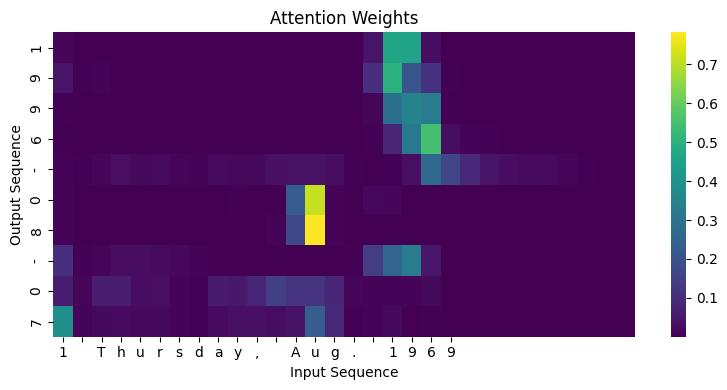

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention_weights, input_sequence, output_sequence):
    # Convert attention weights to numpy array
    attention_weights = attention_weights.squeeze().cpu().detach().numpy()

    # Define figure size and axis labels
    plt.figure(figsize=(8,4))
    sns.heatmap(attention_weights, xticklabels=input_sequence, yticklabels=output_sequence, cmap='viridis')

    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Weights')
    plt.tight_layout()
    plt.show()

# Assuming input_sequence and output_sequence are lists of tokens/words in your sequences
plot_attention(attention_weights, sentence, output_string)


The attention map looks kind of strange, maybe bugs exist.